In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [33]:
import tensorflow as tf      # Deep Learning library
import numpy as np           # Handle matrices
import pandas as pd

import random                # Handling random number generation
import time                  # Handling time calculation
# from skimage import transform# Help us to preprocess the frames

from collections import deque# Ordered collection with ends
import matplotlib.pyplot as plt # Display graphs

import warnings # This ignore all the warning messages that are normally printed during the training because of skiimage
# warnings.filterwarnings('ignore') 

In [34]:
#Variables

BATTERY_CAPACITY = 900
BATTERY_DISCHARGE = 300

MAXIMUM_DEMAND_LIMIT = 1000
PENALITY_EXCEED_DEMAND =  0

DATASET_DIR = 'dataset/aravali.csv'
# DATASET_DIR = 'dataset/test.csv'

class env(object):
    
    
    def __init__ (self):
    
        self.read_dataset()
        self.iter = 0
        
        self.max_battery=BATTERY_CAPACITY
        self.battery=BATTERY_CAPACITY
        self.charge_battery=BATTERY_DISCHARGE
        
        self.reward = 0
        self.exceed_demand = 0
        
        
        self.obs=[]
        self.set_observation()
        self.done = False
        self.info = ""
        self.action_space = [[0,0,1],[0,1,0],[1,0,0]] #['grid', 'battery discharge', 'battery charge']
        self.obs_space = len(self.obs)
       

    #function to change the pricing
    def set_observation(self):
        dict={}
        price=[]
        base_cost = 0
        for x in range(24):
            if(x<8):
                price.append(1)
            elif(x<16):
                price.append(3)               
            else:
                price.append(2)
        dict['price'] = price
        dict['battery'] = self.battery
        dict['load'] = self.dataset['load'][self.iter]
        self.observation =  dict
        self.obs = [p for p in price]
        self.obs.append(self.observation['battery'])
        self.obs.append(self.observation['load'])
    
    
    def read_dataset(self):
        file_location = DATASET_DIR
        try:
            df=pd.read_csv(file_location)
        except e:
            print("Error loading the file, check if file exists !")

        df['load']= df['W1'] + df['W2'] + df['W3']
        for name in list(df):
            if(name not in ['TS','load']):
                df=df.drop(name,axis=1)

        df.fillna(0)  
        self.dataset =  df    
    
    
    def step(self, action):
        
        #Making sure the action taken is valid
        if action not in self.action_space:
            raise ValueError('Invalid Action Space')
        
        #calc reward for the action based on the action choosen
        curr_demand = self.dataset['load'][self.iter]
        grid_price = self.observation['price'][0]
        if(action==self.action_space[0]): #'grid'
            self.reward = curr_demand * grid_price
            if(curr_demand > MAXIMUM_DEMAND_LIMIT):
                self.exceed_demand += 1
            
        if(action==self.action_space[1]): #'battery'
            if(self.battery<=0): #after the battery is completly drained
                self.reward = curr_demand * grid_price
                if(curr_demand > MAXIMUM_DEMAND_LIMIT):
                    self.exceed_demand += 1
            else: 
                battery_satisfy = min(curr_demand, self.charge_battery, self.battery)
                self.battery = self.battery - battery_satisfy
                self.reward =  (curr_demand - battery_satisfy) * grid_price  
                if((curr_demand - battery_satisfy) > MAXIMUM_DEMAND_LIMIT):
                    self.exceed_demand += 1
                
        if(action==self.action_space[2]):  #'charge'
            battery_charge = min(self.charge_battery, self.max_battery-self.battery)
            self.battery = self.battery + battery_charge
            self.reward = (curr_demand+battery_charge) * grid_price
            if((curr_demand + battery_charge) > MAXIMUM_DEMAND_LIMIT):
                    self.exceed_demand += 1
        
        
        #adding the constrain for the Maximum demand
        if(curr_demand >= MAXIMUM_DEMAND_LIMIT):
#             print('Exceed Demand', (curr_demand - MAXIMUM_DEMAND_LIMIT))
            self.reward += (curr_demand - MAXIMUM_DEMAND_LIMIT) * PENALITY_EXCEED_DEMAND
        
        
        self.reward = -1 * self.reward
        self.iter = self.iter+1
        
        #update the pricing for the next observation
        price = self.observation['price'][1:]
        price.append(self.observation['price'][0])
        self.observation['price'] = price
        self.observation['battery'] = self.battery
        #fetch the next load
        self.observation['load'] = self.dataset['load'][self.iter]
        
        
        self.obs = [p for p in price]
        self.obs.append(self.observation['battery'])
        self.obs.append(self.observation['load'])
        
        return self.obs, self.reward, self.done, self.info
    
    
    
    def reset(self):
        self.iter = 0
        self.reward = 0
        self.done = False
        self.info = ""
        self.set_observation()
        self.exceed_demand = 0
        return self.obs
    

    
    def render(self):
        df = self.dataset
        avg=[0.0 for x in range(24)]
        days= int(df.shape[0]/24)   
        print("Number of days in dataset" +str(days))  #The dataset is not good
        days=10
        for i in range(days):
#             plt.plot([x for x in range(24)],df['load'][(i*24):(i*24)+24])
            avg = [ float(a) + float(b) for a,b in zip(avg, df['load'][(i*24):(i*24)+24]) ]

        
        time_shift = self.iter %24
        print("Time shift " +str(time_shift))
        avg = [x/days for x in avg]
        print("Average consumption per day " +str(sum(avg)))
        curr_profile = list(df['load'][(self.iter):self.iter+24])
        
#         print(avg)
#         print(curr_profile)
#         print("Consumption for 10 days")

        x=[a for a in range(24)]
        y=[avg, curr_profile]

        labels = ['Average','Random Day']

        for y_arr, label in zip(y, labels):
            plt.plot(x, y_arr, label=label)
        
        plt.xlabel('time (hours)')
        plt.ylabel('Consumption (Wh)')   
        
        plt.legend()
        plt.show()

Number of days in dataset253
Time shift 0
Average consumption per day 5939.569130586826


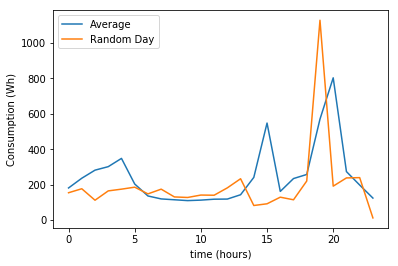

In [35]:
game = env()
game.render()
possible_actions = game.action_space

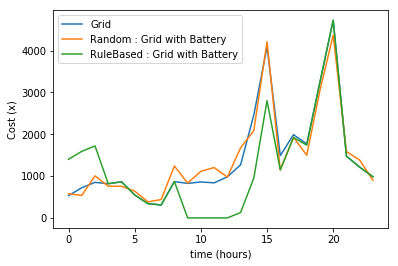

Total Reward Grid Only -340760.5865763156
Total Reward Grid with Random Battery -343096.72503737506
Total Reward Rule Based -288056.50563508103


In [36]:
from random import randint

duration = 24 * 30


# Consume only from grid
a = env()
r_grid = [0 for x in range(24)]
for i in range(duration):
    obs, reward, done, info = a.step(possible_actions[0])
    r_grid[i%24] += reward  

    
# Take actions randomly    
a = env()
r_random = [0 for x in range(24)]
for i in range(duration):
    action = randint(1, 3)
    if(action==1):
        obs, reward, done, info = a.step(possible_actions[0])
        r_random[i%24] += reward  

    elif(action==2):  
        obs, reward, done, info = a.step(possible_actions[1])
        r_random[i%24] += reward 
        
    if(action==3):  
        obs, reward, done, info = a.step(possible_actions[2])
        r_random[i%24] += reward     
    

# Best Action to choose    
a = env()
r_rule = [0 for x in range(24)]
for i in range(duration):
    time = i%24
    action = 1
    
    if(time<9):
        action = 3
    else:
        action = 2
        
    if(action==1):
        obs, reward, done, info = a.step(possible_actions[0])
        r_rule[i%24] += reward  

    elif(action==2):  
        obs, reward, done, info = a.step(possible_actions[1])
        r_rule[i%24] += reward 
        
    if(action==3):  
        obs, reward, done, info = a.step(possible_actions[2])
        r_rule[i%24] += reward    
        


plot_grid = [abs(x/10) for x  in r_grid]
plot_random = [abs(x/10) for x in r_random]
plot_rule = [abs(x/10) for x in r_rule]

x = [a for a in range(24)]
y = [plot_grid, plot_random, plot_rule]
labels = ['Grid', 'Random : Grid with Battery', 'RuleBased : Grid with Battery']


for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)
    
plt.xlabel('time (hours)')
plt.ylabel('Cost (x)')

plt.legend()
plt.show()



print('Total Reward Grid Only', sum(r_grid))
print('Total Reward Grid with Random Battery',sum(r_random))
print('Total Reward Rule Based',sum(r_rule))

In [37]:
### MODEL HYPERPARAMETERS
state_size = [game.obs_space]      
action_size = 3           
learning_rate = 0.00025 #0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 500 #1000 #50000         # Total episodes for training
max_steps = 24*30 #00              # Max possible steps in an episode
batch_size = 32 #64             

# FIXED Q TARGETS HYPERPARAMETERS 
max_tau = 5 #00 #Tau is the C step where we update our target network

# EXPLORATION HYPERPARAMETERS for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0025 # 0.025 #0.0025            # exponential decay rate for exploration prob

# Q LEARNING hyperparameters
gamma = 0.96               # Discounting rate

### MEMORY HYPERPARAMETERS
## If you have GPU change to 1million
pretrain_length = 24*15 # 100000   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 10240 #100000       # Number of experiences the Memory can keep

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

In [38]:
class DDDQNNet:
    def __init__(self, state_size, action_size, learning_rate, name):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.name = name
        
        
        # We use tf.variable_scope here to know which network we're using (DQN or target_net)
        # it will be useful when we will update our w- parameters (by copy the DQN parameters)
        with tf.variable_scope(self.name):
            
            # We create the placeholders
            # *state_size means that we take each elements of state_size in tuple hence is like if we wrote
            # [None, 100, 120, 4]
            
            
            self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
            
            self.ISWeights_ = tf.placeholder(tf.float32, [None,1], name='IS_weights')
            
            self.actions_ = tf.placeholder(tf.float32, [None, action_size], name="actions_")
            
            # Remember that target_Q is the R(s,a) + ymax Qhat(s', a')
            self.target_Q = tf.placeholder(tf.float32, [None], name="target")
            
            
            self.dense1 = tf.layers.dense(inputs = self.inputs_,
                      units = 25,
                      activation = tf.keras.activations.relu,
                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                    name="dense1")
            
            self.dense2 = tf.layers.dense(inputs = self.dense1,
                      units = 25,
                      activation = tf.keras.activations.relu,
                           kernel_initializer=tf.contrib.layers.xavier_initializer(),
                    name="dense2")
            
            
            ## Here we separate into two streams
            # The one that calculate V(s)
            self.value_fc = tf.layers.dense(inputs = self.dense1,
                                  units = 25,
                                  activation = tf.keras.activations.relu,
                                       kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="value_fc")
            
            self.value = tf.layers.dense(inputs = self.value_fc,
                                        units = 1,
                                        activation = None, #tf.keras.activations.linear,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="value")
            
            # The one that calculate A(s,a)
            self.advantage_fc = tf.layers.dense(inputs = self.dense1,
                                  units = 25,
                                  activation = tf.keras.activations.relu,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                  name="advantage_fc")
            
            self.advantage = tf.layers.dense(inputs = self.advantage_fc,
                                units = self.action_size,
                                activation = None, #tf.keras.activations.linear,
                                kernel_initializer=tf.contrib.layers.xavier_initializer(),
                                name="advantages")
            
            # Agregating layer
            # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
            self.output = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))
              
            # Q is our predicted Q value.
            self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_), axis=1)
            
#             # The loss is modified because of PER 
            self.absolute_errors = tf.abs(self.target_Q - self.Q)# for updating Sumtree
            
            self.loss = tf.reduce_mean(self.ISWeights_ * tf.squared_difference(self.target_Q, self.Q))

#             self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
            
            self.optimizer = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)

In [39]:
# Reset the graph
tf.reset_default_graph()

# Instantiate the DQNetwork
DQNetwork = DDDQNNet(state_size, action_size, learning_rate, name="DQNetwork")

# Instantiate the target network
TargetNetwork = DDDQNNet(state_size, action_size, learning_rate, name="TargetNetwork")

In [40]:
class SumTree(object):
    """
    This SumTree code is modified version of Morvan Zhou: 
    https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
    """
    data_pointer = 0
    
    """
    Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    """
    def __init__(self, capacity):
        self.capacity = capacity # Number of leaf nodes (final nodes) that contains experiences
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        """ tree:
            0
           / \
          0   0
         / \ / \
        0  0 0  0  [Size: capacity] it's at this line that there is the priorities score (aka pi)
        """
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
    
    
    """
    Here we add our priority score in the sumtree leaf and add the experience in data
    """
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1
        
        """ tree:
            0
           / \
          0   0
         / \ / \
tree_index  0 0  0  We fill the leaves from left to right
        """
        
        # Update data frame
        self.data[self.data_pointer] = data
        
        # Update the leaf
        self.update (tree_index, priority)
        
        # Add 1 to data_pointer
        self.data_pointer += 1
        
        if self.data_pointer >= self.capacity:  # If we're above the capacity, you go back to first index (we overwrite)
            self.data_pointer = 0
            
    
    """
    Update the leaf priority score and propagate the change through tree
    """
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        # then propagate the change through tree
        while tree_index != 0:    # this method is faster than the recursive loop in the reference code
            
            """
            Here we want to access the line above
            THE NUMBERS IN THIS TREE ARE THE INDEXES NOT THE PRIORITY VALUES
            
                0
               / \
              1   2
             / \ / \
            3  4 5  [6] 
            
            If we are in leaf at index 6, we updated the priority score
            We need then to update index 2 node
            So tree_index = (tree_index - 1) // 2
            tree_index = (6-1)//2
            tree_index = 2 (because // round the result)
            """
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
    
    
    """
    Here we get the leaf_index, priority value of that leaf and experience associated with that index
    """
    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for experiences
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_index = 0
        
        while True: # the while loop is faster than the method in the reference code
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            else: # downward search, always search for a higher priority node
                
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                    
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
            
        data_index = leaf_index - self.capacity + 1

        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node

Here we don't use deque anymore

In [41]:
class Memory(object):  # stored as ( s, a, r, s_ ) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        """
        Remember that our tree is composed of a sum tree that contains the priority scores at his leaf
        And also a data array
        We don't use deque because it means that at each timestep our experiences change index by one.
        We prefer to use a simple array and to overwrite when the memory is full.
        """
        self.tree = SumTree(capacity)
        
    """
    Store a new experience in our tree
    Each new experience have a score of max_prority (it will be then improved when we use this exp to train our DDQN)
    """
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
        # If the max priority = 0 we can't put priority = 0 since this exp will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        
        self.tree.add(max_priority, experience)   # set the max p for new p

        
    """
    - First, to sample a minibatch of k size, the range [0, priority_total] is / into k ranges.
    - Then a value is uniformly sampled from each range
    - We search in the sumtree, the experience where priority score correspond to sample values are retrieved from.
    - Then, we calculate IS weights for each minibatch element
    """
    def sample(self, n):
        # Create a sample array that will contains the minibatch
        memory_b = []
        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment
    
        # Here we increasing the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])  # max = 1
        
        # Calculating the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            """
            A value is uniformly sample from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            
            """
            Experience that correspond to each value is retrieved
            """
            index, priority, data = self.tree.get_leaf(value)
            
            #P(j)
            sampling_probabilities = priority / self.tree.total_priority
            
            #  IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b  /max wi
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight
                                   
            b_idx[i]= index
            
            experience = [data]
            
            memory_b.append(experience)
        
        return b_idx, memory_b, b_ISWeights
    
    """
    Update the priorities on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)

Here we'll **deal with the empty memory problem**: we pre-populate our memory by taking random actions and storing the experience.

In [42]:
# Instantiate memory
memory = Memory(memory_size)

# Render the environment
state = game.reset()

for i in range(pretrain_length):
    
    # Random action
    action = random.choice(possible_actions)
    
    # Get the rewards
    state_next, reward, terminal, done = game.step(action)
#     print(reward)
    # Add experience to memory
    experience = state, action, reward, state_next, done
    
    memory.store(experience)

    # Our state is now the next_state
    state = state_next

## Step 7: Set up Tensorboard 📊
For more information about tensorboard, please watch this <a href="https://www.youtube.com/embed/eBbEDRsCmv4">excellent 30min tutorial</a> <br><br>
To launch tensorboard : `tensorboard --logdir=/tensorboard/dddqn/1`

In [43]:
"""
This function will do the part
With ϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = random.choice(possible_actions)
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        state = np.array([state])
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
#         if(randint(0,100)>95):
#             print(state[0][:4], Qs)
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]
                
    return action, explore_probability

In [44]:
# This function helps us to copy one set of variables to another
# In our case we use it when we want to copy the parameters of DQN to Target_network
# Thanks of the very good implementation of Arthur Juliani https://github.com/awjuliani
def update_target_graph():
    
    # Get the parameters of our DQNNetwork
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQNetwork")
    
    # Get the parameters of our Target_network
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetNetwork")

    op_holder = []
    
    # Update our target_network parameters with DQNNetwork parameters
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

Battery Capacity  1200 , Try Count 0
0  Exploring  0.9975280911734855, Reward 333778.4962623244,./training/during_train0/model0.ckpt  Model Saved ,./training/during_train10/model0.ckpt  Model Saved ,./training/during_train20/model0.ckpt  Model Saved ,./training/during_train30/model0.ckpt  Model Saved ,./training/during_train40/model0.ckpt  Model Saved ,./training/during_train50/model0.ckpt  Model Saved ,./training/during_train60/model0.ckpt  Model Saved ,./training/during_train70/model0.ckpt  Model Saved ,./training/during_train80/model0.ckpt  Model Saved ,./training/during_train90/model0.ckpt  Model Saved ,100  Exploring  0.7790876507109202, Reward 336916.83685510367,./training/during_train100/model0.ckpt  Model Saved ,./training/during_train110/model0.ckpt  Model Saved ,./training/during_train120/model0.ckpt  Model Saved ,./training/during_train130/model0.ckpt  Model Saved ,./training/during_train140/model0.ckpt  Model Saved ,./training/during_train150/model0.ckpt  Model Saved ,./tra

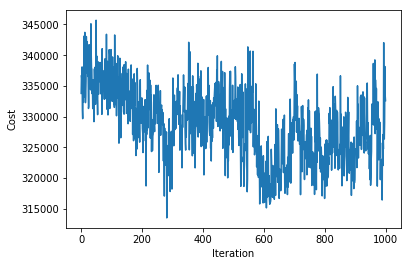

Battery Capacity  1200 , Try Count 1
0  Exploring  0.9975280911734855, Reward 336072.7272293136,./training/during_train0/model1.ckpt  Model Saved ,./training/during_train10/model1.ckpt  Model Saved ,./training/during_train20/model1.ckpt  Model Saved ,./training/during_train30/model1.ckpt  Model Saved ,./training/during_train40/model1.ckpt  Model Saved ,./training/during_train50/model1.ckpt  Model Saved ,./training/during_train60/model1.ckpt  Model Saved ,./training/during_train70/model1.ckpt  Model Saved ,./training/during_train80/model1.ckpt  Model Saved ,./training/during_train90/model1.ckpt  Model Saved ,100  Exploring  0.7790876507109202, Reward 331488.32502583606,./training/during_train100/model1.ckpt  Model Saved ,./training/during_train110/model1.ckpt  Model Saved ,./training/during_train120/model1.ckpt  Model Saved ,./training/during_train130/model1.ckpt  Model Saved ,./training/during_train140/model1.ckpt  Model Saved ,./training/during_train150/model1.ckpt  Model Saved ,./tra

In [ ]:
%%time
import sys

DATASET_DIR = 'dataset/aravali.csv'

total_episodes = 1000

cap = [1200] #[c for c in range(5000,25000,5000)]

tr = []

for try_capacity in cap:
#     total_episodes = int(float(try_capacity) * 0.023)
    BATTERY_CAPACITY = 0.8 * try_capacity
    BATTERY_DISCHARGE = 0.7 * try_capacity
    
    for try_count in range(3):
        
        # Saver will help us to save our model
        saver = tf.train.Saver()
        game = env()
        
        print('Battery Capacity ', try_capacity , end = ' , ')
        print('Try Count', try_count)
        curr_min = sys.maxsize
        
        if training == True:
            with tf.Session() as sess:
                # Initialize the variables
                sess.run(tf.global_variables_initializer())
#                 saver.restore(sess,"./training/b_default"+str(try_capacity)+"/model.ckpt")
#                 saver.restore(sess,"./final_models/mdl_8500/model.ckpt")

                # Initialize the decay rate (that will use to reduce epsilon) 
                decay_step = 0

                # Set tau = 0
                tau = 0

                # Init the game
                game.reset()

                # Update the parameters of our TargetNetwork with DQN_weights
                update_target = update_target_graph()
                sess.run(update_target)


                total_rewards = []
                for episode in range(total_episodes):
                    # Set step to 0
                    step = 0

                    # Initialize the rewards of the episode
                    episode_rewards = []

                    # Make a new episode and observe the first state
                    state = game.reset()

                    curr_reward = 0

                    decay_step +=1

                    tau += 1
                    while step < max_steps:
                        step += 1

                        # With ϵ select a random action atat, otherwise select a = argmaxQ(st,a)
        #                 print(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)
                        action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)

                        # Do the action
                        state_next, reward, terminal, done = game.step(action)

                        #to plot the rewards
                        curr_reward = curr_reward + abs(reward)

                        # Add the reward to total reward
                        episode_rewards.append(reward)

                        # Add experience to memory
                        experience = state, action, reward, state_next, done
                        memory.store(experience)

                        # st+1 is now our current state
                        state = state_next

                        ### LEARNING PART            
                        # Obtain random mini-batch from memory
                        tree_idx, batch, ISWeights_mb = memory.sample(batch_size)

                        states_mb = np.array([each[0][0] for each in batch])
                        actions_mb = np.array([each[0][1] for each in batch])
                        rewards_mb = np.array([each[0][2] for each in batch]) 
                        next_states_mb = np.array([each[0][3] for each in batch])
                        dones_mb = np.array([each[0][4] for each in batch])

                        target_Qs_batch = []


                        ### DOUBLE DQN Logic
                        # Use DQNNetwork to select the action to take at next_state (a') (action with the highest Q-value)
                        # Use TargetNetwork to calculate the Q_val of Q(s',a')

                        # Get Q values for next_state 
                        q_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})

                        # Calculate Qtarget for all actions that state
                        q_target_next_state = sess.run(TargetNetwork.output, feed_dict = {TargetNetwork.inputs_: next_states_mb})


                        # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma * Qtarget(s',a') 
                        for i in range(0, len(batch)):

                            # We got a'
                            action = np.argmax(q_next_state[i])

                            # Take the Qtarget for action a'
                            target = rewards_mb[i] + gamma * q_target_next_state[i][action]
                            target_Qs_batch.append(target)


                        targets_mb = np.array([each for each in target_Qs_batch])

        #                 print(states_mb.shape, targets_mb.shape, actions_mb.shape, ISWeights_mb.shape)                

                        _, loss, absolute_errors = sess.run([DQNetwork.optimizer, DQNetwork.loss, DQNetwork.absolute_errors],
                                            feed_dict={DQNetwork.inputs_: states_mb,
                                                       DQNetwork.target_Q: targets_mb,
                                                       DQNetwork.actions_: actions_mb,
                                                      DQNetwork.ISWeights_: ISWeights_mb})



                        # Update priority
                        memory.batch_update(tree_idx, absolute_errors)


                        if tau > max_tau:
                            # Update the parameters of our TargetNetwork with DQN_weights
                            update_target = update_target_graph()
                            sess.run(update_target)
                            tau = 0
#                             print("Model update")


                    total_rewards.append(curr_reward)

                    # Save model every 5 episodes
                    if episode % 100 == 0:
                        print(episode, " Exploring ", explore_probability, end = ',')
                        print(" Reward", curr_reward, end = ',')
                        
                    if episode % 10 == 0:    
                        if ((curr_reward < curr_min)):
                            save_path = saver.save(sess, "./training/during_train"+str(episode)+"/model"+str(try_count)+".ckpt")
                            print(save_path, " Model Saved ", end = ',')
#                         print( "Loss ", loss) 
                        
        tr.append(total_rewards)                
        plt.plot(total_rewards)
        plt.xlabel('Iteration')
        plt.ylabel('Cost')   
        plt.show()


## Step 9: Watch our Agent play 👀
Now that we trained our agent, we can test it

In [30]:
test_days = 30

saver = tf.train.Saver()
checking =[]
DATASET_DIR = 'dataset/test.csv'

models = ["./training/b_default"+str(cc)+"/model.ckpt" for cc in range(5000,25000,5000)]
capacities = [cc for cc in range(1000,25000,1000)]
# for model_sav in ["./mdl_500/model.ckpt", "./mdl_1500/model.ckpt",
#                   "./mdl_2500/model.ckpt", "./mdl_3500/model.ckpt",
#                   "./mdl_4500/model.ckpt", "./mdl_6500/model.ckpt"]:
    
for model_sav in models:
#     model_sav = "./final_models/t_mdl_"+str(c)+"/model.ckpt"
    answer = []

    for try_capacity in capacities:
        BATTERY_CAPACITY = 0.8 * try_capacity
        BATTERY_DISCHARGE = 0.7 * try_capacity

        for try_count in range(1):
            with tf.Session() as test_sess:

                test_game = env()

                # Load the model
                try:
                    saver.restore(test_sess, model_sav)

                except Exception as e:
                    print(e)
                    continue
                test_state = test_game.reset()


                test_rewards = []
                test_battery=[]

                for i in range(24*test_days):
                    ## EPSILON GREEDY STRATEGY
                    # Choose action a from state s using epsilon greedy.
                    ## First we randomize a number
                    test_exp_exp_tradeoff = np.random.rand()

                    test_state = np.array([test_state])
                    test_Qs = test_sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: test_state})

                    # Take the biggest Q value (= the best action)
                    test_choice = np.argmax(test_Qs)
                    test_action = possible_actions[int(test_choice)]

                    test_state, test_reward, test_terminal, test_done = test_game.step(test_action)
            #         print(test_state[:4], test_Qs, test_choice)

                    test_battery.append(test_state[-2])
                    test_rewards.append(test_reward)

#                 print("Score: ", sum(test_rewards))
                answer.append(abs(sum(test_rewards)))


            test_battery_status = [[] for i in range(24)]
            test_time = -1

            for test_i in range(0, 24*test_days):
                test_time +=1
                test_battery_status[test_time%24].append(test_battery[test_i])

    checking.append(answer)


INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default5000/model.ckpt
INFO:tensorflow:Restoring parameters from ./training/b_default50

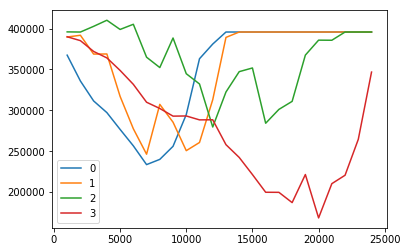

In [31]:
for i in range(len(checking)):
    plt.plot(capacities,checking[i], label=str(i))
plt.legend()    
plt.show()    
     

In [37]:
for ii in range(len(answer)):
    print(min([checking[xx][ii] for xx in range(len(checking))]),end =',')

945311.3008769427,933508.1659349921,921109.850234806,908472.8432788011,896041.4925709326,886441.5277708649,879474.7931528098,873900.6775391386,868956.7909961662,859814.192873858,853352.6955693094,846239.0125310369,835656.11469655,810229.6712193775,788167.9862818609,750947.0556212908,791622.2510873461,790091.0179963894,

In [71]:
with tf.Session() as temp_sess:
    saver.restore(temp_sess, "./models_2000_0/model.ckpt")
    saver.save(temp_sess, "./final_models/model_base.ckpt")

INFO:tensorflow:Restoring parameters from ./models_2000_0/model.ckpt


In [20]:
savings_percent = []

for model in checking:
    saving = []
    for cap in model:
        saving.append(((checking[0][0]-cap)/checking[0][0])*100 )
    savings_percent.append(saving)

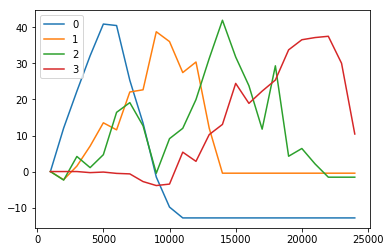

In [32]:
for i in range(len(savings_percent)):
    plt.plot(capacities,savings_percent[i], label=str(i))
plt.legend()    
plt.show()    
     

In [19]:
for i in range(len(savings_percent)):
    plt.plot(capacities,savings_percent[i], label=str(i))
plt.legend()    
plt.show()    
     

NameError: name 'savings_percent' is not defined

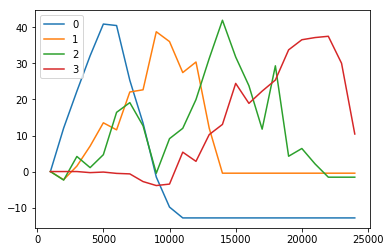

In [23]:
for i in range(len(savings_percent)):
    plt.plot(capacities,savings_percent[i], label=str(i))
plt.legend()    
plt.show()    
     

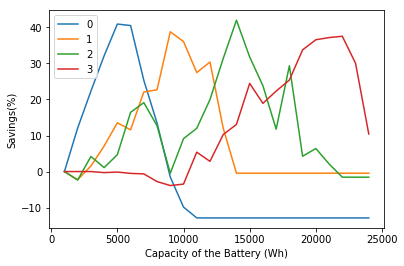

In [22]:
from math import nan

savings_percent = []

for model in checking:
    saving = []
    for cap in model:
        val = ((model[0]-cap)/model[0])*100
        if val == 100:
            saving.append(nan)
        else:
            saving.append(val)
    savings_percent.append(saving)

for i in range(len(savings_percent)):
    plt.plot(capacities,savings_percent[i], label=str(i))
plt.xlabel('Capacity of the Battery (Wh)')
plt.ylabel('Savings(%)')

plt.legend()    
plt.show()    


In [ ]:
from scipy.ndimage.filters import gaussian_filter1d


for i in range(len(savings_percent)):
    ysmoothed = gaussian_filter1d(savings_percent[i], sigma=2)
#     ysmoothed(ysmoothed==100) = NaN
    plt.plot(capacities, ysmoothed, label="Apartment "+str(i+1))
plt.xlabel('Capacity of the Battery (Wh)')
plt.ylabel('Savings(%)')

plt.legend()    
plt.show()    
